### QED-C Application-Oriented Benchmarks - Analyze Observable Methods

The notebook implements a procedure for analyzing different methods for computing observables.
Given a specific problem size (number of qubits), a Hamiltonian, an aboservable method (group_method), and a given total shot count, generate a specified number of random input states, and measure the resulting expectation value, both exactly and computed using the quantum expactation algorithm.

Results are plotted and the difference between the exact expectation value at each random input and the computed value is highlighted.

DEVNOTE: Much of the code in this notebook will be re-factored into other modules, as this work evolves.


### Program Configuration

In [1]:
# Select the API to use and load the benchmark program
api = "qiskit"
import hamlib_simulation_benchmark

# configure the QED-C Benchmark package for use with the given API
_, _ = hamlib_simulation_benchmark.qedc_benchmarks_init(api)

# Select the benchmark parameters
num_qubits = min_qubits = max_qubits = 10
skip_qubits=1
max_circuits=1
num_shots=1000

# Select the backend 
#backend_id="qasm_simulator"
backend_id="statevector_simulator"
provider_backend=None
exec_options={}

#############

# place resulting data and images into a folder with "paper" suffix
import metrics
metrics.data_suffix = "_analysis"
hamlib_simulation_benchmark.data_suffix = "_analysis"

hamlib_simulation_benchmark.max_qubits_exact = 10

skip_execution = False


In [2]:
import numpy as np
import time
import os

# Configure module paths
import sys
sys.path.insert(1, "_common")
sys.path.insert(1, "qiskit")

sys.path.insert(1, "../_common/qiskit")
import execute

# Import HamLib helper functions (from _common)
import hamlib_utils

# Import Hamlib Simulation kernel (from qiskit)
import hamlib_simulation_kernel

# Import Observable helper functions
import observables
import evolution_exact

verbose = True

#### for executing circuits to compute observables ...

# Import Qiskit and Qiskit Pauli operator classes
#from qiskit.quantum_info import Pauli, SparsePauliOp
#from qiskit import QuantumCircuit

# Initialize simulator backend
#from qiskit_aer import Aer
#backend = Aer.get_backend('qasm_simulator')

backend_id = "qasm_simulator"
exec_options = {}

# Custom optimization options can be specified in this cell (below is an example)

import sys
sys.path.insert(1, "../")

# # Define a custom noise model to be used during execution
import _common.custom.custom_qiskit_noise_model as custom_qiskit_noise_model
exec_options.update({ "noise_model": custom_qiskit_noise_model.my_noise_model() })

execute.set_execution_target(backend_id, exec_options=exec_options)

# object used to store metrics
metrics_object = {}


### List of Available Hamiltonians and Sizes
For the example illustrated below, select one of the available Hamiltonian (name, params, size) tuples.


In [3]:
# List of HamLib filename and parameter tuples, with max_qubits limit array
# Note that the 4th entry in the array is used in the cell below which executes a noisy simulation

# DEVNOTE: this notebook does not currently use the last field of the items in this array

hamiltonians = [
    ('condensedmatter/tfim/tfim', { "1D-grid": "pbc", "h": 2 }, [24,28,28,28, 16] ),
    ('condensedmatter/heisenberg/heis', { "1D-grid": "pbc", "h": 2 }, [24,28,28,28, 16] ),
    ('condensedmatter/fermihubbard/FH_D-1', { "1D-grid": "pbc", "enc": "bk", "U":12 }, [20,24,24,24, 14] ),
    ('condensedmatter/bosehubbard/BH_D-1_d-4', { "1D-grid": "nonpbc", "enc": "gray", "U":10 }, [16,24,24,24, 12] ),
    ('binaryoptimization/max3sat/random/random_max3sat-hams', { "ratio": "2", "rinst": "02" }, [18,28,28,28, 14] ),
    ('chemistry/electronic/standard/H2', { "ham_BK": "" }, [8,12,12,12, 8] )
    ]

# Select indices of the Hamiltonian(s) to test
ham_indexes = range(len(hamiltonians))       # select all
#ham_indexes = [2,3]       # select subset, for example 2,3; for quick test, do just one of them

# get Hamiltonian name and params from list
# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[ 3 ]     # just do TFIM for now

###########

# list of observable computation methods to sweep
group_method_list = [ None, "simple", "N", "estimator" ]

# limit testing to simple for now
# group_method = "simple"
# use_diag_method = False

group_method = "N"
use_diag_method = True
num_k = 4

print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")

# this could be a loop ...

print("============================================================\n")
print(f"Testing expectation grouping method: {group_method}\n") 



*******************************************************************************************

Analyze Observable Computation Methods for condensedmatter/bosehubbard/BH_D-1_d-4 {'1D-grid': 'nonpbc', 'enc': 'gray', 'U': 10}


Testing expectation grouping method: N



### Load the Given Hamiltonian to get its Pauli terms

In [4]:
# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)
print(f"... dataset_name = {dataset_name}")
print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")

print("")

... dataset_name = bh_graph-1D-grid-nonpbc-qubitnodes_Lx-5_U-10_enc-gray_d-4
... sparse_pauli_terms = 
[({}, (50+0j)), ({0: 'X', 1: 'Z', 2: 'X'}, (-0.24999999999999994+0j)), ({0: 'X', 1: 'Z', 2: 'X', 3: 'Z'}, (0.06698729810778066+0j)), ({0: 'X', 1: 'Z', 2: 'Z', 3: 'X'}, (0.12940952255126037+0j)), ({0: 'X', 1: 'Z', 3: 'X'}, (-0.12940952255126037+0j)), ({0: 'X', 2: 'X'}, (0.9330127018922193+0j)), ({0: 'X', 2: 'X', 3: 'Z'}, (-0.24999999999999994+0j)), ({0: 'X', 2: 'Z', 3: 'X'}, (-0.48296291314453416+0j)), ({0: 'X', 3: 'X'}, (0.48296291314453416+0j)), ({0: 'Y', 1: 'Z', 2: 'Y'}, (-0.24999999999999994+0j)), ({0: 'Y', 1: 'Z', 2: 'Y', 3: 'Z'}, (0.9330127018922193+0j)), ({0: 'Y', 1: 'Z', 2: 'Z', 3: 'Y'}, (-0.48296291314453416+0j)), ({0: 'Y', 1: 'Z', 3: 'Y'}, (0.48296291314453416+0j)), ({0: 'Y', 2: 'Y'}, (0.06698729810778066+0j)), ({0: 'Y', 2: 'Y', 3: 'Z'}, (-0.24999999999999994+0j)), ({0: 'Y', 2: 'Z', 3: 'Y'}, (0.12940952255126037+0j)), ({0: 'Y', 3: 'Y'}, (-0.12940952255126037+0j)), ({0: 'Z'}, 

### Arrange Pauli Terms into Commuting Groups

In [5]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below
pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method)

print(f"... Number of groups created: {len(pauli_term_groups)}")
print(f"... Pauli Term Groups:")
for group in pauli_term_groups:
    print(group)
        

... Number of groups created: 12
... Pauli Term Groups:
[('IIIIIIIIII', (50+0j)), ('IZIIIIIIII', (-10+0j)), ('IIIZIIIIII', (-10+0j)), ('IIIIIZIIII', (-10+0j)), ('IIIIIIIZII', (-10+0j)), ('IIIIIIIIIZ', (-10+0j)), ('ZIIIIIIIII', (5+0j)), ('ZZIIIIIIII', (-5+0j)), ('IIZIIIIIII', (5+0j)), ('IIZZIIIIII', (-5+0j)), ('IIIIZIIIII', (5+0j)), ('IIIIZZIIII', (-5+0j)), ('IIIIIIZIII', (5+0j)), ('IIIIIIZZII', (-5+0j)), ('IIIIIIIIZI', (5+0j)), ('IIIIIIIIZZ', (-5+0j))]
[('XIXIIIIIII', (0.9330127018922193+0j)), ('IIXIXIIIII', (0.9330127018922193+0j)), ('IIIIXIXIII', (0.9330127018922193+0j)), ('IIIIIIXIXI', (0.9330127018922193+0j)), ('XIIXIIIIII', (0.48296291314453416+0j)), ('IXXIIIIIII', (0.48296291314453416+0j)), ('IIXIIXIIII', (0.48296291314453416+0j)), ('IIIXXIIIII', (0.48296291314453416+0j)), ('IIIIXIIXII', (0.48296291314453416+0j)), ('IIIIIXXIII', (0.48296291314453416+0j)), ('IIIIIIXIIX', (0.48296291314453416+0j)), ('IIIIIIIXXI', (0.48296291314453416+0j)), ('IXIXIIIIII', (0.25000000000000006+0j)), 

### Ansatz Definition - Suitable Quantum Circuit for Initial State
Select the type of ansatz circuit to use

DEVNOTE: this analysis does not currently use the ansatz, but it will later.


In [6]:
import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit import QuantumCircuit

def get_ansatz(num_qubits, params):
    ansatz = EfficientSU2(num_qubits).decompose()
    ansatz.barrier()

    params_dict = {p: params[i] for i, p in enumerate(ansatz.parameters)}

    # Use assign_parameters instead of bind_parameters
    ansatz = ansatz.assign_parameters(params_dict)
    
    return ansatz

# Create the ansatz
ansatz = EfficientSU2(num_qubits)

num_params = ansatz.num_parameters

# Generate initial parameters with correct length
initial_params = np.random.uniform(-np.pi, np.pi, ansatz.num_parameters)
print(initial_params)

# Get the ansatz circuit
ansatz_circuit = get_ansatz(num_qubits, initial_params)
print(ansatz_circuit)


[ 0.307  1.352  0.646  0.282 -0.48   0.917 -0.392  2.462  2.913 -0.732
  1.833  0.182  0.428  2.674 -2.695 -2.594 -3.015  2.09   1.748  2.325
  3.007  1.88  -0.242  1.763 -2.398  0.879 -2.241  2.794  0.137 -0.536
 -1.479  1.723 -0.276  0.43  -3.024  0.739  0.704  0.735  2.788  1.142
 -0.883 -0.396  1.242 -2.763  1.048  1.072 -1.82  -2.332 -1.16  -0.856
  0.441 -0.386  3.069 -2.5   -1.829 -2.128  0.962 -1.55  -0.212 -1.606
 -2.143 -2.448  0.982 -2.273 -1.906 -0.825  2.017 -2.531  2.123 -2.538
  2.994 -0.197  2.996  0.659  1.503 -2.895 -1.365 -2.386 -1.281 -2.396]
      ┌────────────┐  ┌───────────┐                                     »
q_0: ─┤ Ry(0.3067) ├──┤ Rz(1.833) ├─────────────────────────────────────»
      ├────────────┤ ┌┴───────────┴┐                                    »
q_1: ─┤ Ry(1.3521) ├─┤ Rz(0.18155) ├────────────────────────────────────»
     ┌┴────────────┤ ├─────────────┤                                    »
q_2: ┤ Ry(0.64568) ├─┤ Rz(0.42754) ├─────────────────────────

### Create Measurement Circuits from Base Circuit and Pauli Terms
Here, we append basis rotation gates for each Pauli Term group to the base evolution circuit to create an array of circuits for execution.

In [7]:
# generate an array of circuits, one for each pauli_string in list
def create_measurement_circuts(qc, num_qubits, pauli_term_groups, pauli_str_list):
    ts = time.time()

    # use normal basis rotation and measurement circuits
    if not use_diag_method:
        circuits = hamlib_simulation_kernel.create_circuits_for_pauli_terms(qc, num_qubits, pauli_str_list)
    
    # option to use new method for producing diagonalized measurement circuts with N-qubit groups
    else:
        #print(f"... ****** using diagonalization method for measurement circuits")
        
        # generate an array of circuits, one for each pauli_string in list
        from generate_measurement_circuits import create_circuits_for_pauli_terms_k_commute    
        circuits = [create_circuits_for_pauli_terms_k_commute(qc, ops, num_k) for ops in pauli_term_groups]
    
    """
    print(f"... Appended {len(circuits)} circuits, one for each group:")               
    for circuit, group in list(zip(circuits, pauli_term_groups)):
        print(group)
        #print(circuit)
    """
    
    append_time = round(time.time()-ts, 3)
    metrics_object["append_measurements_time"] = append_time
    ###print(f"\n... finished appending {len(circuits)} measurement circuits, total creating time = {append_time} sec.\n")

    return circuits


In [8]:
def do_execute(circuits, num_shots):

    if skip_execution:
        return []
    
    # Initialize simulator backend
    from qiskit_aer import Aer
    #####backend = Aer.get_backend('qasm_simulator')
    #backend = Aer.get_backend('statevector_simulator')     # doesn't work, only returns 1 shot
    
    ### print(f"... begin executing {len(circuits)} circuits ...")
    ts = time.time()
    
    # Execute all of the circuits to obtain array of result objects
    ###### results = backend.run(circuits, num_shots=num_shots, noise_model=execute.noise).result()

    results = hamlib_simulation_benchmark.execute_circuits(
                                    backend_id = backend_id,
                                    circuits = circuits,
                                    num_shots = int(num_shots / len(circuits))
                                    )

    #for ca in results.get_counts():
    #    print(ca)
    
    exec_time = round(time.time()-ts, 3)
    metrics_object["execute_circuits_time"] = exec_time
    ###print(f"... finished executing {len(circuits)} circuits, total execution time = {exec_time} sec.\n")

    return results


In [9]:
# Compute the total energy for the Hamiltonian
def compute_energy(num_qubits, results, pauli_term_groups):

    ###print(f"... begin computing observable value ...")
    ts = time.time()
    
    total_energy, term_contributions = observables.calculate_expectation_from_measurements(
                                                num_qubits, results, pauli_term_groups)
    obs_time = round(time.time()-ts, 3)
    metrics_object["observable_compute_time"] = obs_time
    ###print(f"... finished computing observable value, computation time = {obs_time} sec.\n")
    
    #print(f"    Total Energy: {round(np.real(total_energy), 4)}")
    ### print(f"    Term Contributions: {term_contributions}\n")

    create_time = 0
    group_time = 0
    append_time = 0
    exec_time = 0
    
    total_time = group_time + create_time + append_time + exec_time + obs_time
    total_time = round(total_time, 3)   
    metrics_object["total_time"] = total_time
    ###print(f"\n... total observable computation time = {total_time} sec.\n")
    
    return total_energy


In [10]:
# Compute exact value
def compute_exact_value(num_qubits, init_state, sparse_pauli_terms):
    
    #print(f"... begin classical computation of expectation value ...")                 
    ts = time.time()

    if num_qubits <= hamlib_simulation_benchmark.max_qubits_exact:
        
        correct_exp, correct_dist = evolution_exact.compute_expectation_exact(
                init_state,
                observables.ensure_pauli_terms(sparse_pauli_terms, num_qubits),
                0.0            # time
                )
    else:
        correct_exp = 0.001
        correct_dist = None
            
    exact_time = round(time.time()-ts, 3)
    metrics_object["exact_time"] = exact_time
    """
    print(f"... exact computation time = {exact_time} sec")
    
    print(f"\nExact expectation value, computed classically: {round(np.real(correct_exp), 4)}")
    print(f"Estimated expectation value, computed using quantum algorithm: {round(np.real(total_energy), 4)}\n")
    """
    #simulation_quality = round(np.real(total_energy) / np.real(correct_exp), 3)
    #print(f"    ==> Simulation Quality: {np.real(simulation_quality)}\n")

    return correct_exp 


In [11]:
import random

def generate_random_int_and_bitstring(N):
    """
    Generates a random bitstring representing an integer from 0 to N-1,
    where N is a power of 2.

    Args:
        N (int): The upper bound (exclusive), must be a power of 2.

    Returns:
        str: A random bitstring representation of an integer in range [0, N-1].
    """
    if N <= 0 or (N & (N - 1)) != 0:
        raise ValueError("N must be a power of 2.")

    num_bits = N.bit_length() - 1  # Determine the number of bits needed
    random_number = random.randint(0, N - 1)  # Pick a random number in range [0, N-1]
    
    return random_number, format(random_number, f'0{num_bits}b')  # Convert to bitstring with leading zeros


In [12]:
def estimate_expectation_value_top(num_qubits, sparse_pauli_terms, group_method, num_shots):
    global metrics_object

    #reset the metrics object
    metrics_object = {}
    
    ######### Group Commuting Terms

    # Arrange the Pauli terms into commuting groups based on group_method
    pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method)

    ######### Create Base Circuit
    
    # create Trotterized evolution circuit for HamLib Hamiltonian
    ts = time.time()
    qc, _ = hamlib_simulation_kernel.HamiltonianSimulation(
        num_qubits=num_qubits, 
        #ham_op=sparse_pauli_terms,
        K = 0, t = 0.0,
        init_state = init_state,
        append_measurements = False,
        method = 1, 
    )

    create_time = round(time.time()-ts, 3)
    metrics_object["create_base_time"] = create_time
    #print(f"\n... finished creating base circuit, total creation time = {create_time} sec.\n")

    #print(qc)

    ######### Append Measurement Circuits
    
    # Append measurement circuits for each term group and return an array of circuits
    circuits = create_measurement_circuts(qc, num_qubits, pauli_term_groups, pauli_str_list)

    #for c in circuits:
    #    print(c)

    ######### Execution
    
    results = do_execute(circuits, num_shots)

    ######### Compute Energy
    
    energy = compute_energy(num_qubits, results, pauli_term_groups)
    energy = np.real(energy)

    return energy



---
### Generate N Random Input States and Collect Data about Computation of Observable (Energy)


In [13]:
# Number of iterations performed with random initialization
iterations = 50

tracker_style = 1     # controls style of output printed each iteration - 1 - dots, 2 - detailed

print(f"... executing on num_qubits = {num_qubits}")
N = 2 ** num_qubits

# create arrays to hold metrics
init_values = []
exact_energies = []
computed_energies = []
metrics_array = []

# For each iteration, generate random input, compute observable, and store data
for it in range(iterations):

    ######### Initialize
    """
    # Create a quantum ansatz circuit with the given parameters (update later to use Parameter)
    qc = get_ansatz(num_qubits, params)  
    #print(qc)
    """
    init_value, init_state = generate_random_int_and_bitstring(N)
    init_values.append(init_value)

    ######### Compute Exact Energy
    
    exact_energy = compute_exact_value(num_qubits, init_state, sparse_pauli_terms)
    exact_energies.append(exact_energy)

    ######### Estimate Energy using Quantum Algorithm
    
    # estimate expectation using the benchmark functions
    energy = estimate_expectation_value_top(num_qubits, sparse_pauli_terms, group_method, num_shots)
    
    computed_energies.append(energy)
    metrics_array.append(metrics_object)
    
    # print important data at each iteration
    if tracker_style > 1:
        print(f"  {count:3} \t{energy: <7.5}  \t{[round(params[i], 4) for i in range(len(params))]} ")
    else:
        print(".", end='')

# print("")
# print(init_values)
# print("")
# print(exact_energies)
# print("")
# print(computed_energies)
# print("")
# print(metrics_array)


... executing on num_qubits = 10
..................................................

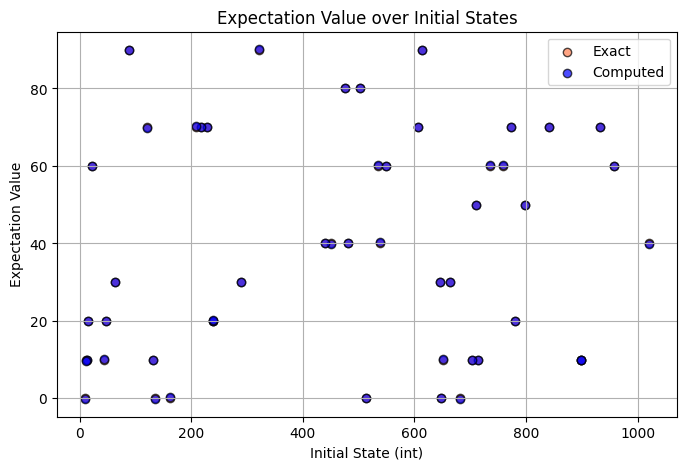

In [14]:
import matplotlib.pyplot as plt

def plot_scatter(x_values, y_values, y_values_2):
    """
    Plots a scatter plot with x_values on the x-axis and y_values on the y-axis.

    Args:
        x_values (list or array): Values for the x-axis.
        y_values (list or array): Values for the y-axis.
    """
    if len(x_values) != len(y_values):
        raise ValueError("Both input arrays must have the same length.")

    plt.figure(figsize=(8, 5))  # Set figure size
    plt.scatter(x_values, y_values, color='coral', alpha=0.7, edgecolors='black', label='Exact')
    plt.scatter(x_values, y_values_2, color='blue', alpha=0.7, edgecolors='black', label='Computed')

    plt.xlabel("Initial State (int)")
    plt.ylabel("Y Values")
    plt.ylabel("Expectation Value")
    plt.title("Expectation Value over Initial States")
    plt.grid(True)

    plt.legend()

    plt.show()

# plot the data we collected
plot_scatter(init_values, exact_energies, computed_energies)


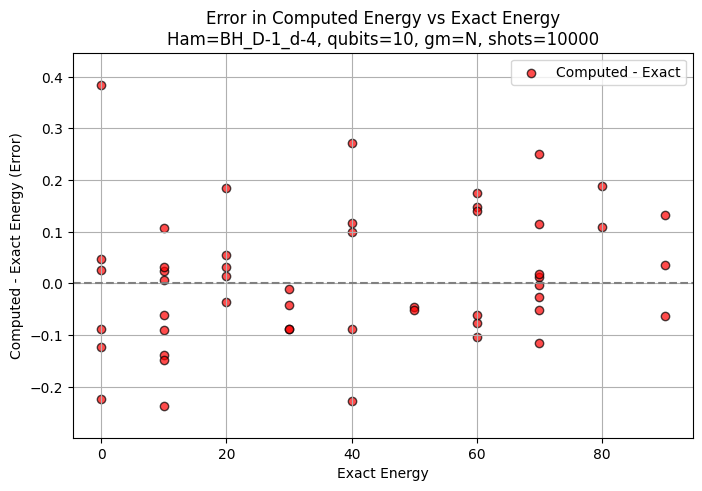

In [15]:
import matplotlib.pyplot as plt

def plot_error(exact_energies, computed_energies):
    """
    Plots the difference (computed - exact) against exact_energies.

    Args:
        exact_energies (list or array): Exact energy values (x-axis).
        computed_energies (list or array): Computed energy values.

    """
    if len(exact_energies) != len(computed_energies):
        raise ValueError("Arrays must have the same length.")

    base_ham_name = os.path.basename(hamiltonian_name)
    
    # Compute the difference (error)
    errors = [computed - exact for computed, exact in zip(computed_energies, exact_energies)]

    # Create scatter plot
    plt.figure(figsize=(8, 5))
    plt.scatter(exact_energies, errors, color='red', alpha=0.7, edgecolors='black', label='Computed - Exact')

    # Labels and title
    title = "Error in Computed Energy vs Exact Energy"
    title += f"\nHam={base_ham_name}, qubits={num_qubits}, gm={group_method}, shots={num_shots}" 
    plt.title(title)
    
    plt.xlabel("Exact Energy")
    plt.ylabel("Computed - Exact Energy (Error)")
    plt.axhline(0, color='gray', linestyle='--')  # Add horizontal line at 0 for reference
    plt.grid(True)

    ymin = min(errors)
    ymax = max(errors)
    ydelta = ymax - ymin
    ymin -= 0.10 * ydelta
    ymax += 0.10 * ydelta
    
    #plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)  

    plt.legend()

    imagename = f"{base_ham_name}-{num_qubits}-{group_method}-value-error"
    metrics.save_plot_image(plt, imagename, backend_id)

    plt.show()
    
plot_error(exact_energies, computed_energies)


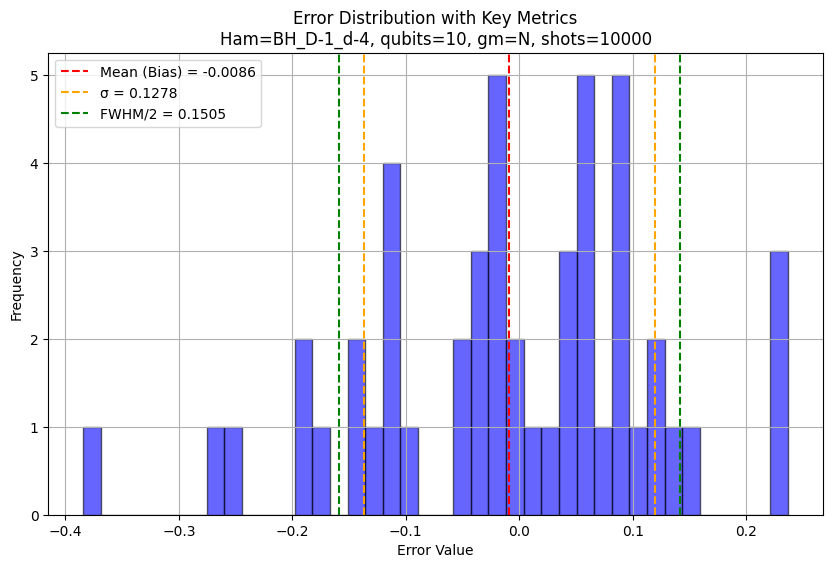


🔹 **Bias Detection**
Mean Error (Bias) = -0.0086
✅ No significant bias detected.


In [16]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_error_distribution(errors):
    """
    Plots the histogram of the error distribution and overlays key statistical metrics.
    Works for any distribution (not just Gaussian).

    Args:
        errors (list or array): List of error values.
    """
    base_ham_name = os.path.basename(hamiltonian_name)
    
    title = "Error Distribution with Key Metrics"
    title += f"\nHam={base_ham_name}, qubits={num_qubits}, gm={group_method}, shots={num_shots}" 
    
    errors = np.array(errors)

    # Compute key error metrics
    std_dev = np.std(errors)  # Standard deviation (σ)
    mean_error = np.mean(errors)  # Mean error (detects bias)
    mae = np.mean(np.abs(errors))  # Mean Absolute Error (MAE)
    rmse = np.sqrt(np.mean(errors**2))  # Root Mean Square Error (RMSE)

    # Compute Full Width at Half Maximum (FWHM) estimate
    fwhm = 2.355 * std_dev  # Approximate FWHM if shape is roughly symmetric

    # Create histogram without assuming normality
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=40, color='blue', alpha=0.6, edgecolor='black')

    plt.title(title)
    
    # Plot key statistics
    plt.axvline(mean_error, color='red', linestyle="--", label=f"Mean (Bias) = {mean_error:.4f}")
    plt.axvline(mean_error + std_dev, color='orange', linestyle="--", label=f"σ = {std_dev:.4f}")
    plt.axvline(mean_error - std_dev, color='orange', linestyle="--")
    plt.axvline(mean_error + fwhm/2, color='green', linestyle="--", label=f"FWHM/2 = {fwhm/2:.4f}")
    plt.axvline(mean_error - fwhm/2, color='green', linestyle="--")

    # Labels & legend
    plt.xlabel("Error Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)

    imagename = f"{base_ham_name}-{num_qubits}-{group_method}-value-error-distr"
    metrics.save_plot_image(plt, imagename, backend_id)

    plt.show()

    # Print error bias analysis
    bias_direction = "positive" if mean_error > 0 else "negative"
    print("\n🔹 **Bias Detection**")
    print(f"Mean Error (Bias) = {mean_error:.4f}")
    
    # More general bias detection without assuming Gaussian shape
    if abs(mean_error) > 0.5 * (np.max(errors) - np.min(errors)) / 4:  # Using range-based threshold
        print(f"⚠️ Warning: Significant {bias_direction} bias detected in the error distribution!")
    else:
        print("✅ No significant bias detected.")

visualize_error_distribution(np.array(exact_energies) - np.array(computed_energies))


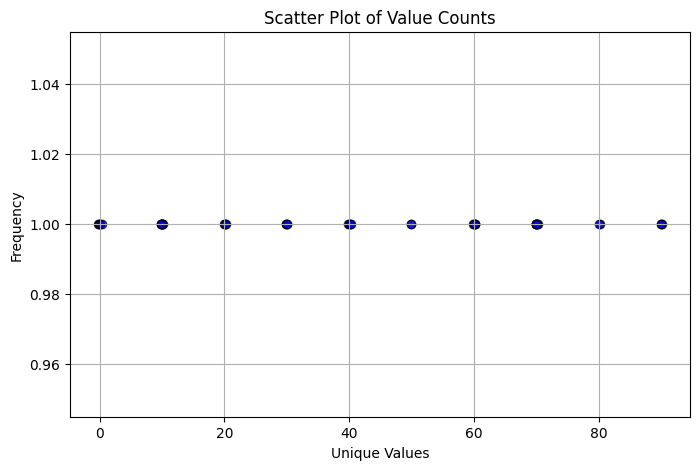

In [17]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_value_counts(x_values):
    """
    Plots a scatter plot where the x-axis represents unique values from x_values,
    and the y-axis represents their frequency (number of occurrences).

    Args:
        x_values (list or array): Values for the x-axis.
    """
    # Count occurrences of each unique value
    value_counts = Counter(x_values)

    # Extract unique values and their counts
    unique_x = list(value_counts.keys())
    counts = list(value_counts.values())

    # Create scatter plot
    plt.figure(figsize=(8, 5))
    plt.scatter(unique_x, counts, color='blue', alpha=0.7, edgecolors='black')

    # Labels and title
    plt.xlabel("Unique Values")
    plt.ylabel("Frequency")
    plt.title("Scatter Plot of Value Counts")
    plt.grid(True)

    plt.show()

plot_value_counts(computed_energies)


In [18]:
import numpy as np

def compute_timing_stats(metrics_list):
    """
    Computes the average and standard deviation of selected timing metrics.

    Args:
        metrics_list (list): A list of dictionaries containing timing metrics.

    Returns:
        dict: A dictionary containing both the average and standard deviation for selected fields.
    """
    if not metrics_list:
        return {}

    # Define fields that should have both avg and stddev 
    selected_fields = ['create_base_time', 'append_measurements_time', 'execute_circuits_time', 'observable_compute_time']

    # Initialize result dictionary
    stats = {}

    # Compute averages and stddevs for selected fields
    for key in selected_fields:
        values = [d[key] for d in metrics_list if key in d]  # Only use existing keys
        if values:  # Ensure we don't compute on an empty list
            stats[key] = np.mean(values)
            stats[f"{key}_stddev"] = np.std(values, ddof=1)

    # Compute averages for all fields (without stddev) including 'exact_time'
    all_keys = set().union(*metrics_list)  # Get all unique keys from all dictionaries
    for key in all_keys:
        if key not in stats:  # Only compute if not already processed
            values = [d[key] for d in metrics_list if key in d]  # Filter missing keys
            if values:
                stats[key] = np.mean(values)

    return stats

# Example usage
timing_metrics = [
    {'exact_time': 0.252, 'append_measurements_time': 0.001, 'execute_circuits_time': 0.039, 'observable_compute_time': 0.002, 'total_time': 0.002},
    {'exact_time': 0.260, 'append_measurements_time': 0.002, 'execute_circuits_time': 0.045, 'observable_compute_time': 0.003, 'total_time': 0.003},
    {'exact_time': 0.248, 'append_measurements_time': 0.001, 'execute_circuits_time': 0.042, 'observable_compute_time': 0.002, 'total_time': 0.002},
]

print(metrics_array)
stats_result = compute_timing_stats(metrics_array)
print(stats_result)


[{'create_base_time': 0.0, 'append_measurements_time': 0.016, 'execute_circuits_time': 0.458, 'observable_compute_time': 0.059, 'total_time': 0.059, 'exact_time': 0.249}, {'create_base_time': 0.0, 'append_measurements_time': 0.016, 'execute_circuits_time': 0.494, 'observable_compute_time': 0.057, 'total_time': 0.057, 'exact_time': 0.224}, {'create_base_time': 0.0, 'append_measurements_time': 0.016, 'execute_circuits_time': 0.536, 'observable_compute_time': 0.059, 'total_time': 0.059, 'exact_time': 0.263}, {'create_base_time': 0.0, 'append_measurements_time': 0.01, 'execute_circuits_time': 0.474, 'observable_compute_time': 0.06, 'total_time': 0.06, 'exact_time': 0.24}, {'create_base_time': 0.0, 'append_measurements_time': 0.009, 'execute_circuits_time': 0.441, 'observable_compute_time': 0.059, 'total_time': 0.059, 'exact_time': 0.229}, {'create_base_time': 0.0, 'append_measurements_time': 0.0, 'execute_circuits_time': 0.633, 'observable_compute_time': 0.058, 'total_time': 0.058, 'exact_

[[0.122 0.467 0.706 1.   ]
 [0.173 0.627 0.173 1.   ]
 [0.549 0.337 0.294 1.   ]
 [0.498 0.498 0.498 1.   ]
 [0.09  0.745 0.812 1.   ]]


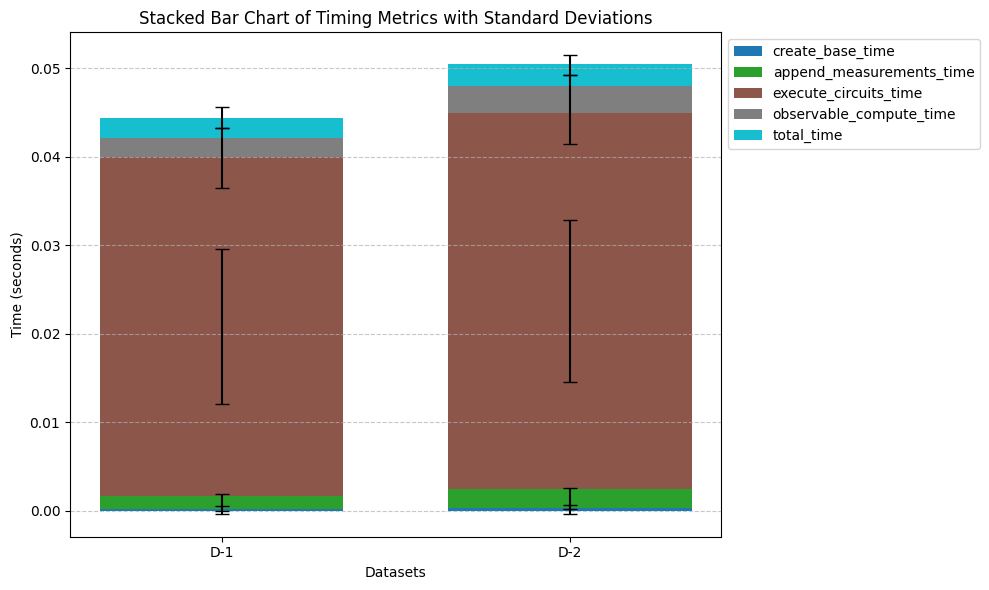

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def plot_stacked_bars_with_std(datasets, dataset_labels):
    """
    Plots a stacked bar chart for multiple datasets with standard deviations as error bars.

    Args:
        datasets (list of dicts): Each dict contains mean and stddev values for a dataset.
        dataset_labels (list of dicts): Parallel array containing names and labels for datasets.
    """
    # Define the categories (excluding stddev fields)
    categories = [key for key in datasets[0] if not key.endswith('_stddev') and key != 'exact_time']
    
    # Set up figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Number of datasets
    num_datasets = len(datasets)
    bar_width = 0.7  # Width of each bar
    x_positions = np.arange(num_datasets)  # X positions for the bars

    # Initialize bottom positions for stacking
    bottoms = np.zeros(num_datasets)

    # Define colors for different categories
    colors = plt.cm.tab10(np.linspace(0, 1, len(categories)))
    print(colors)

    for i, category in enumerate(categories):
        means = [dataset[category] for dataset in datasets]
        stddevs = [dataset.get(f"{category}_stddev", 0) for dataset in datasets]  # Default to 0 if missing
        
        # Plot the stacked bar for this category
        bars = ax.bar(x_positions, means, bar_width, label=category, bottom=bottoms, color=colors[i])

        # Plot standard deviation as error bars
        ax.errorbar(x_positions, np.array(bottoms) + np.array(means) / 2, yerr=stddevs, fmt='none', ecolor='black', capsize=5)

        # Update the bottom position for next stack
        bottoms += means

    # Set x-axis labels using dataset names
    ax.set_xticks(x_positions)
    ax.set_xticklabels([label['label'] for label in dataset_labels])

    # Add labels and legend
    ax.set_xlabel("Datasets")
    ax.set_ylabel("Time (seconds)")
    ax.set_title("Stacked Bar Chart of Timing Metrics with Standard Deviations")
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

    # Show grid and tight layout
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Example usage
datasets = [
    {'create_base_time': 0.00022, 'create_base_time_stddev': 0.00042, 'append_measurements_time': 0.00146, 'append_measurements_time_stddev': 0.00096,
     'execute_circuits_time': 0.03828, 'execute_circuits_time_stddev': 0.00875, 'observable_compute_time': 0.00218, 'observable_compute_time_stddev': 0.00459,
     'exact_time': 0.230, 'total_time': 0.00218},
    
    {'create_base_time': 0.00035, 'create_base_time_stddev': 0.00050, 'append_measurements_time': 0.00210, 'append_measurements_time_stddev': 0.00120,
     'execute_circuits_time': 0.04250, 'execute_circuits_time_stddev': 0.00910, 'observable_compute_time': 0.00300, 'observable_compute_time_stddev': 0.00500,
     'exact_time': 0.250, 'total_time': 0.00250}
]

dataset_labels = [
    {"name": "Dataset 1", "label": "D-1"},
    {"name": "Dataset 2", "label": "D-2"}
]

plot_stacked_bars_with_std(datasets, dataset_labels)



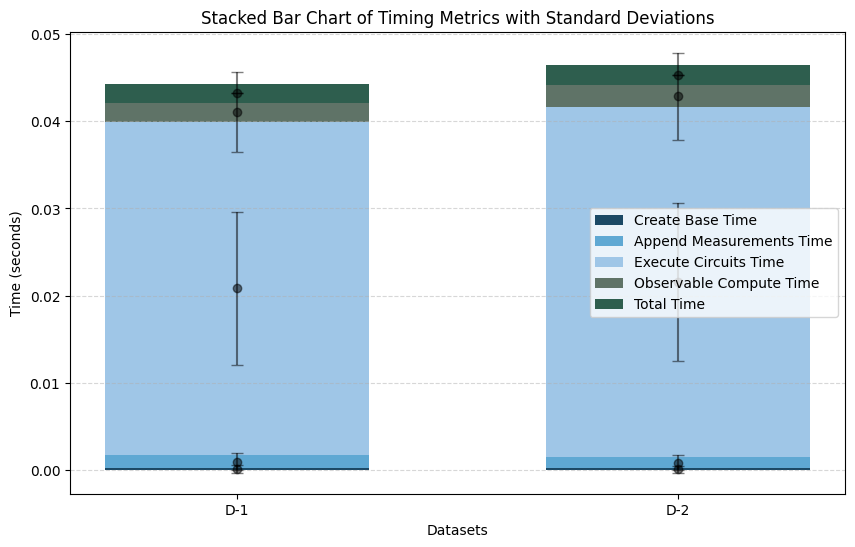

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def plot_stacked_bar_chart(datasets, dataset_labels, x_label="Datasets"):
    """
    Plots a stacked bar chart for multiple datasets, showing standard deviation using error markers.

    Args:
        datasets (list of dicts): A list of dictionaries, each containing timing metrics and stddev values.
        dataset_labels (list of dicts): A list of dictionaries, each containing metadata (e.g., name, label).
        x_label (str): Label for the x-axis.
    """
    if not datasets or len(datasets) != len(dataset_labels):
        raise ValueError("Datasets and labels must have the same length.")

    # Define colors for each timing component
    colors = {
        "create_base_time": "blue",
        "append_measurements_time": "orange",
        "execute_circuits_time": "green",
        "observable_compute_time": "red",
        "total_time": "purple"
    }

    colors = {
        "create_base_time": "#7F886A",  # Muted Olive Green
        "append_measurements_time": "#B0926A",  # Warm Brown
        "execute_circuits_time": "#4F6D7A",  # Soft Teal Blue
        "observable_compute_time": "#A7A37E",  # Faded Khaki
        "total_time": "#6B5B95"  # Deep Lavender
    }

    colors = {
        "create_base_time": "#A7C7E7",  # Soft Sky Blue
        "append_measurements_time": "#B5D6B2",  # Light Sage Green
        "execute_circuits_time": "#809BCE",  # Muted Blue
        "observable_compute_time": "#5D6D7E",  # Slate Gray
        "total_time": "#5B84B1"  # Deep Cool Blue
    }

    colors = {
        "create_base_time": "#264653",  # Deep Teal
        "append_measurements_time": "#2A9D8F",  # Rich Green-Teal
        "execute_circuits_time": "#E9C46A",  # Warm Golden Yellow
        "observable_compute_time": "#F4A261",  # Muted Orange
        "total_time": "#E76F51"  # Deep Reddish-Orange
    }

    colors = {
        "create_base_time": "#1E3A5F",  # Deep Navy Blue
        "append_measurements_time": "#297373",  # Teal Green
        "execute_circuits_time": "#F2A541",  # Strong Golden Yellow
        "observable_compute_time": "#D72638",  # Deep Red
        "total_time": "#A020F0"  # Strong Purple
    }

    colors = {
        "create_base_time": "#1B4965",  # Deep Steel Blue
        "append_measurements_time": "#5FA8D3",  # Muted Sky Blue
        "execute_circuits_time": "#9FC6E7",  # Soft Light Blue
        "observable_compute_time": "#5F7367",  # Subtle Green-Gray
        "total_time": "#2E5E4E"  # Deep Forest Green
    }

    # colors = {
    #     "create_base_time": "#455A64",  # Cool Dark Gray
    #     "append_measurements_time": "#607D8B",  # Slate Gray-Blue
    #     "execute_circuits_time": "#81A1C1",  # Muted Soft Blue
    #     "observable_compute_time": "#4C738A",  # Deep Slate Blue
    #     "total_time": "#2C6674"  # Dark Teal
    # }



    

    # Extract metric names (ignoring stddev fields)
    metric_names = [key for key in datasets[0].keys() if not key.endswith("_stddev") and key != "exact_time"]

    num_datasets = len(datasets)
    num_metrics = len(metric_names)

    # Bar width and dataset positioning
    bar_width = 0.6
    x_positions = np.arange(num_datasets)

    # Create stacked bar segments
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Initialize bottom positions for stacking
    bottoms = np.zeros(num_datasets)

    for metric in metric_names:
        values = np.array([dataset[metric] for dataset in datasets])  # Convert to NumPy array
        stddevs = np.array([dataset.get(f"{metric}_stddev", 0) for dataset in datasets])  # Convert to NumPy array

        # Plot stacked bars
        ax.bar(x_positions, values, width=bar_width, label=metric.replace("_", " ").title(), bottom=bottoms, color=colors.get(metric, "gray"))

        # Add error bars using transparent markers
        ax.errorbar(x_positions, bottoms + values / 2, yerr=stddevs, fmt='o', color='black', alpha=0.5, capsize=4)

        # Update bottom positions for next stacked layer
        bottoms += values

    # X-axis labels (Dataset names)
    dataset_labels_formatted = [d["label"] for d in dataset_labels]
    ax.set_xticks(x_positions)
    ax.set_xticklabels(dataset_labels_formatted)

    # Labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel("Time (seconds)")
    ax.set_title("Stacked Bar Chart of Timing Metrics with Standard Deviations")

    # Legend
    ax.legend()

    # Grid for clarity
    ax.grid(axis="y", linestyle="--", alpha=0.5)

    plt.show()

# Example usage with multiple datasets
datasets = [
    {'create_base_time': 0.00022, 'create_base_time_stddev': 0.00042, 'append_measurements_time': 0.00146, 'append_measurements_time_stddev': 0.00096, 'execute_circuits_time': 0.03828, 'execute_circuits_time_stddev': 0.00875, 'observable_compute_time': 0.00218, 'observable_compute_time_stddev': 0.00459, 'total_time': 0.00218},
    {'create_base_time': 0.00020, 'create_base_time_stddev': 0.00039, 'append_measurements_time': 0.00130, 'append_measurements_time_stddev': 0.00090, 'execute_circuits_time': 0.04010, 'execute_circuits_time_stddev': 0.00910, 'observable_compute_time': 0.00250, 'observable_compute_time_stddev': 0.00500, 'total_time': 0.00230},
]

dataset_labels = [
    {"name": "Dataset 1", "label": "D-1"},
    {"name": "Dataset 2", "label": "D-2"},
]

plot_stacked_bar_chart(datasets, dataset_labels)


{'create_base_time': np.float64(0.00068), 'create_base_time_stddev': np.float64(0.003165115982657424), 'append_measurements_time': np.float64(0.0104), 'append_measurements_time_stddev': np.float64(0.012310606013034584), 'execute_circuits_time': np.float64(0.49488), 'execute_circuits_time_stddev': np.float64(0.0872020033471428), 'observable_compute_time': np.float64(0.0583), 'observable_compute_time_stddev': np.float64(0.002643822217617391), 'total_time': np.float64(0.0583), 'exact_time': np.float64(0.2350408163265306)}
0.8


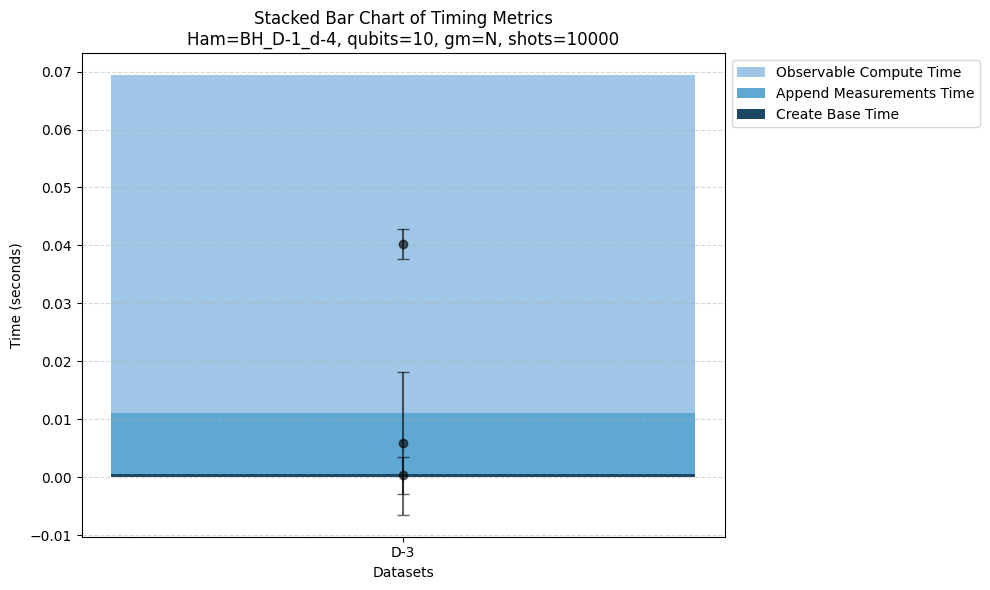

0.8


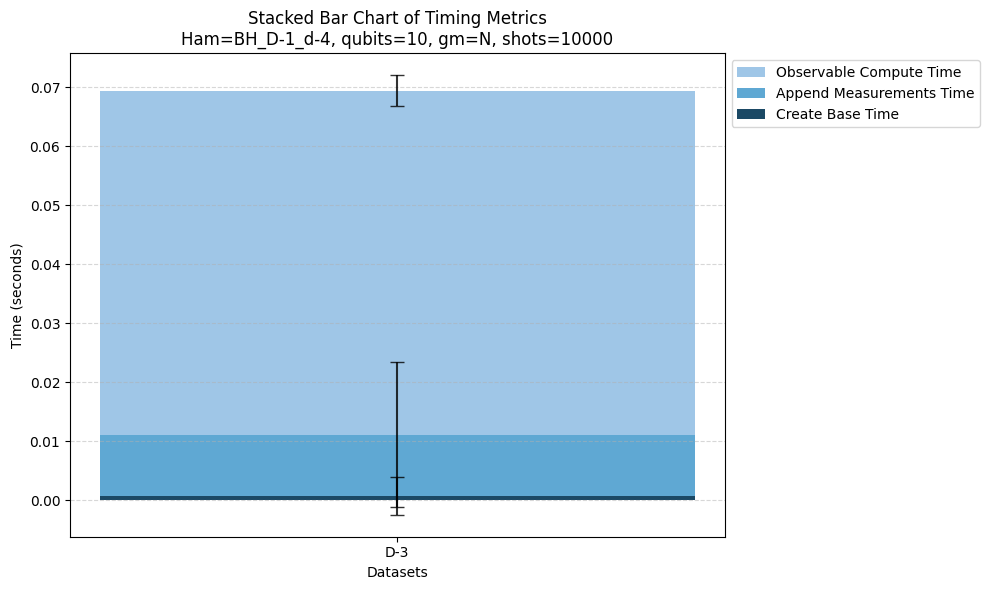

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def plot_stacked_bar_chart(datasets, dataset_labels, x_label="Datasets", error_bar_position="middle"):
    """
    Plots a stacked bar chart for multiple datasets with standard deviations.

    Args:
        datasets (list of dicts): List of dictionaries containing mean & stddev values for each dataset.
        dataset_labels (list of dicts): List containing metadata (e.g., name, label) for each dataset.
        x_label (str): Label for the x-axis.
        error_bar_position (str): "middle" for stddev markers at the middle, "top" for error bars at the top.
    """
    if not datasets or len(datasets) != len(dataset_labels):
        raise ValueError("Datasets and labels must have the same length.")

    base_ham_name = os.path.basename(hamiltonian_name)
    
    #title = "Error Distribution with Key Metrics"
    title = "Stacked Bar Chart of Timing Metrics"
    title += f"\nHam={base_ham_name}, qubits={num_qubits}, gm={group_method}, shots={num_shots}" 

    # Define categories (excluding stddev fields)
    categories = [key for key in datasets[0] if not key.endswith("_stddev") and key != "exact_time" and key != 'execute_circuits_time' and key != 'total_time'  ]

    # Scale bar width dynamically
    num_datasets = len(datasets)
    bar_width = max(0.2, 0.8 / num_datasets)  # Ensures bars are visible and not too thin
    print(bar_width)
    #bar_width = 0.2

    x_positions = np.arange(num_datasets)  # X positions for each dataset

    # x_positions = np.array([0]) if num_datasets == 1 else np.arange(num_datasets)  # Fix for single dataset
    # bar_width = 0.5 if num_datasets > 1 else 0.3  # Adjust bar width for single dataset

    # Define colors for different categories
    colors = plt.cm.tab10(np.linspace(0, 1, len(categories)))

    # we are currently only using the color by its index, not the key name
    colors = {
        "create_base_time": "#1B4965",  # Deep Steel Blue
        "append_measurements_time": "#5FA8D3",  # Muted Sky Blue
        "execute_circuits_time": "#9FC6E7",  # Soft Light Blue
        "observable_compute_time": "#5F7367",  # Subtle Green-Gray
        "total_time": "#2E5E4E"  # Deep Forest Green
    }

    #print(colors)
    color_list = list(colors.values())  # Convert dictionary values to a list    

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Initialize bottoms for stacking
    bottoms = np.zeros(num_datasets)

    for i, category in enumerate(categories):
        values = np.array([dataset[category] for dataset in datasets])
        stddevs = np.array([dataset.get(f"{category}_stddev", 0) for dataset in datasets])

        # Plot stacked bars
        ax.bar(x_positions, values, bar_width, label=category.replace("_", " ").title(), bottom=bottoms, color=color_list[i], align='center')

        # bar_width = min(0.8, 0.6 / num_datasets)  # Keeps bars visible but prevents full-width issue
        # x_positions = np.linspace(-bar_width * (num_datasets - 1) / 2, bar_width * (num_datasets - 1) / 2, num_datasets)  # Evenly space bars
        # ax.bar(x_positions + i, values, bar_width, label=category.replace("_", " ").title(), bottom=bottoms, color=color_list[i])


        # Plot standard deviation
        if error_bar_position == "middle":
            # Place markers at the middle of each bar segment
            ax.errorbar(x_positions, bottoms + values / 2, yerr=stddevs, fmt='o', color='black', capsize=4, alpha=0.6)
        elif error_bar_position == "top":
            # Place error bars at the top of each bar segment
            ax.errorbar(x_positions, bottoms + values, yerr=stddevs, fmt='none', ecolor='black', capsize=5, alpha=0.8)

        # Update stacking positions
        bottoms += values

    # X-axis labels
    dataset_labels_formatted = [d["label"] for d in dataset_labels]
    ax.set_xticks(x_positions)
    ax.set_xticklabels(dataset_labels_formatted)

    # Labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel("Time (seconds)")
    ax.set_title(title)

    # Legend
    #ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

    # Add legend, but reverse its order to match the stacked bars
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc="upper left", bbox_to_anchor=(1, 1))

    # Grid for readability
    ax.grid(axis="y", linestyle="--", alpha=0.5)

    plt.tight_layout()

    imagename = f"{base_ham_name}-{num_qubits}-{group_method}-timing-metrics"
    metrics.save_plot_image(plt, imagename, backend_id)
    
    plt.show()

# Example usage with multiple datasets
datasets = [
    

    #stats_result,
    stats_result

]
print(stats_result)

dataset_labels = [
    #{"name": "Dataset 1", "label": "D-1"},
    #{"name": "Dataset 2", "label": "D-2"},
    {"name": "Dataset 3", "label": "D-3"},
]

# Version 1: Markers in the middle of the bars
plot_stacked_bar_chart(datasets, dataset_labels, error_bar_position="middle")

# Version 2: Error bars at the top of the bars
plot_stacked_bar_chart(datasets, dataset_labels, error_bar_position="top")
